# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.705702,False,0.777604
1,-0.722924,False,0.254183
2,-1.196482,False,-0.266708
3,0.208196,True,5.037153
4,-0.463076,False,0.448151
...,...,...,...
995,2.028265,True,6.113425
996,0.005487,True,5.582877
997,-0.841498,False,-0.535029
998,0.599228,False,-0.558594


<AxesSubplot: xlabel='v0'>

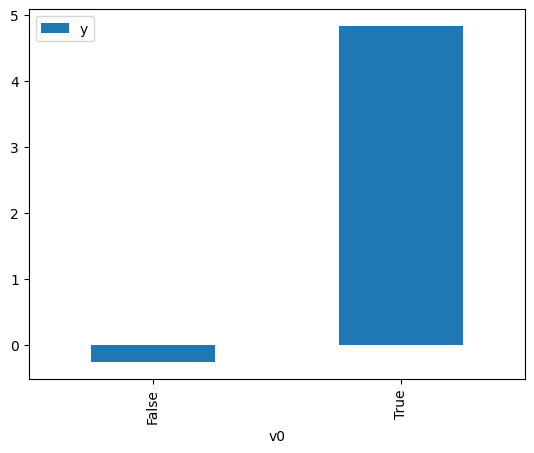

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

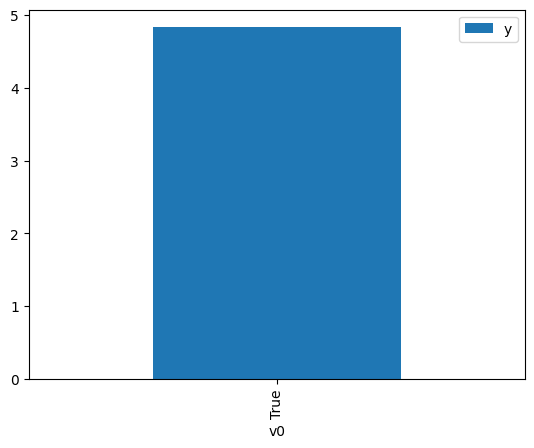

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.553711,False,-1.179089,0.310538,3.220219
1,-0.390818,False,-0.570843,0.651146,1.535755
2,-2.435624,False,-1.150935,0.975917,1.024677
3,-1.045019,False,0.018907,0.833241,1.200134
4,-1.483632,False,-1.642655,0.906274,1.103420
...,...,...,...,...,...
995,-1.196482,False,-0.266708,0.862564,1.159335
996,-0.936044,False,-0.679079,0.809188,1.235807
997,-0.796628,False,-1.472232,0.774674,1.290865
998,0.822705,False,0.056048,0.231032,4.328396


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.476455,True,4.874720,0.899031,1.112309
1,-0.180613,True,4.901348,0.423680,2.360270
2,0.903581,True,2.938442,0.789883,1.266010
3,0.335088,True,5.156702,0.615038,1.625916
4,0.922991,True,7.601631,0.794691,1.258350
...,...,...,...,...,...
995,-1.114014,True,2.918919,0.152824,6.543466
996,0.262943,True,4.524670,0.589028,1.697713
997,0.165627,True,5.638084,0.553166,1.807777
998,-0.004075,True,4.941065,0.489511,2.042855


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              6036.
Date:                Thu, 15 Dec 2022   Prob (F-statistic):                        0.00
Time:                        14:41:36   Log-Likelihood:                         -1378.8
No. Observations:                1000   AIC:                                      2762.
Df Residuals:                     998   BIC:                                      2771.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4472      0.031     14.453      0.000       0.387       0.508
x2             4.8994      0.048    102.744      0.000       4.806       4.993
==============================================================================
Omnibus:                        2.729   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.256   Jarque-Bera (JB):                2.685
Skew:                           0.090   Prob(JB):                        0.261
Kurtosis:                       2.820   Cond. No.                         1.64
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""